In [1]:
import pandas as pd
import numpy as np
import random
import copy
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier


from sklearn import tree
from sklearn import svm

from sklearn import metrics
from itertools import combinations

# Read in Data

In [2]:
import pandas as pd
data = pd.ExcelFile("OppScrData.xlsx")

In [3]:
data1 = data.parse(0)

In [4]:
# remove unnamed column
for i in data1:
    if i.startswith('Unnamed') or i.startswith('CLINICAL OUTCOMES') or i.startswith('AUTO-CT'):
        data1.pop(i)
    
data1 = data1.dropna(axis = 0,how='all') # Remove Rows with All NAS

# Create Binary Indicators

In [5]:
def replace_binary_indicator(df,c1,c2,t):
    if c2 != "":
        df.loc[df.loc[:,c1:c2].any(axis=1),t] = 1 
        df.loc[~df.loc[:,c1:c2].any(axis=1),t] = 0
        df = df.drop(df.loc[:,c1:c2],axis=1)
    else:
        df.loc[~df.loc[:,c1].isnull(),t] = 1 
        df.loc[df.loc[:,c1].isnull(),t] = 0
        df = df.drop(c1,axis=1)
    df[t] = df[t].astype(np.uint8)

    return df

In [6]:
data2 = data1.copy()
data2 = replace_binary_indicator(data2,"Alcohol abuse","","AA_FLAG")

data2 = replace_binary_indicator(data2,"CVD DX","MI DX Date [d from CT]","CARD_FLAG")
data2 = replace_binary_indicator(data2,"Type 2 Diabetes DX","Type 2 Diabetes DX Date [d from CT]","DIA_FLAG")
data2 = replace_binary_indicator(data2,"Femoral neck fracture DX","Pathologic fracture DX Date [d from CT]","FEM_FLAG")
data2 = replace_binary_indicator(data2,"Alzheimers DX","Alzheimers DX Date [d from CT]","ALZ_FLAG")
data2 = replace_binary_indicator(data2,"Primary Cancer Site","Primary Cancer Site 2 Dx [d from CT]","CANCER_FLAG")

data2["OUTCOME_FLAGS"] = data2.loc[:,"CARD_FLAG":"CANCER_FLAG"].sum(axis = 1)
data2["OUTCOME_FLAGS"] = pd.Categorical(data2["OUTCOME_FLAGS"])

data2 = replace_binary_indicator(data2,"DEATH [d from CT]","","DEATH_FLAG")
data2

# We do a reshuffle to "AA_Flag" is next to the other clinical data
data2 = pd.concat([data2.loc[:,"Record ID":"Met Sx"],data2.loc[:,"AA_FLAG"],data2.loc[:,"L1_HU_BMD":"Liver HU    (Median)"],data2.loc[:,"CARD_FLAG":"DEATH_FLAG"]], axis = 1)

# Create Column Index

In [7]:
# print column name with corresponding number
for count, name in enumerate(data2):
    print(f'{count}:"{name}",')

0:"Record ID",
1:"Visit ID",
2:"PT ID",
3:"Clinical F/U interval  [d from CT]",
4:"BMI",
5:"BMI >30",
6:"Sex",
7:"Age at CT",
8:"Tobacco",
9:"FRS 10-year risk (%)",
10:"FRAX 10y Fx Prob (Orange-w/ DXA)",
11:"FRAX 10y Hip Fx Prob (Orange-w/ DXA)",
12:"Met Sx",
13:"AA_FLAG",
14:"L1_HU_BMD",
15:"TAT Area (cm2)",
16:"Total Body                Area EA (cm2)",
17:"VAT Area (cm2)",
18:"SAT Area (cm2)",
19:"VAT/SAT     Ratio",
20:"Muscle HU",
21:" Muscle Area (cm2)",
22:"L3 SMI (cm2/m2)",
23:"AoCa        Agatston",
24:"Liver HU    (Median)",
25:"CARD_FLAG",
26:"DIA_FLAG",
27:"FEM_FLAG",
28:"ALZ_FLAG",
29:"CANCER_FLAG",
30:"OUTCOME_FLAGS",
31:"DEATH_FLAG",


In [8]:
# define a lookup table for the column
columns = {0:"Record ID",
1:"Visit ID",
2:"PT ID",
3:"Clinical F/U interval  [d from CT]",
4:"BMI",
5:"BMI >30",
6:"Sex",
7:"Age at CT",
8:"Tobacco",
9:"FRS 10-year risk (%)",
10:"FRAX 10y Fx Prob (Orange-w/ DXA)",
11:"FRAX 10y Hip Fx Prob (Orange-w/ DXA)",
12:"Met Sx",
13:"AA_FLAG",
14:"L1_HU_BMD",
15:"TAT Area (cm2)",
16:"Total Body                Area EA (cm2)",
17:"VAT Area (cm2)",
18:"SAT Area (cm2)",
19:"VAT/SAT     Ratio",
20:"Muscle HU",
21:" Muscle Area (cm2)",
22:"L3 SMI (cm2/m2)",
23:"AoCa        Agatston",
24:"Liver HU    (Median)",
25:"CARD_FLAG",
26:"DIA_FLAG",
27:"FEM_FLAG",
28:"ALZ_FLAG",
29:"CANCER_FLAG",
30:"OUTCOME_FLAGS",
31:"DEATH_FLAG",
}

# define different groups of column
clinical_data_columns = {i:columns[i] for i in range(14)}
CT_data = {i:columns[i] for i in range(14,25)}
clinical_outcome_columns = {i:columns[i] for i in range(25,32)}

# Visualize Data

In [9]:
import matplotlib.pyplot as plt

def removenan(a, sorting=True, specialStr=None):
    result = []
    missing = []
    special = []
    for count, value in enumerate(a):
        if special != None and value == specialStr:
            special.append(count)
            continue
        
        if not pd.isna(value):
            result.append(value) 
        else:
            missing.append(count)
    if sorting:
        result.sort()
    return result, missing, special


# Data Cleaning

In [10]:
data3 = data2.copy()

# BMI - Remove Outliers (Less than 10 and those with Missing values)
data3 = data3[ (data3["BMI"] > 10)]

# BMI > 30 - Check to make sure this is all the missing values in the "BMI > 30" column (it is)
#print(len(data3[ (data3["BMI >30"].isna())])) # We rmoved all NAs from this group

# Tobacco - Create new category for the NAs
data3["Tobacco"] = data3["Tobacco"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Met Sx - Create new category for the NAs
data3["Met Sx"] = data3["Met Sx"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Remove Rows wth Special Characters
data3 = data3[ (data3["FRS 10-year risk (%)"] !=  "X")]
data3 = data3[ (data3["FRAX 10y Fx Prob (Orange-w/ DXA)"] !=  "_")]
data3 = data3[ (data3["FRAX 10y Hip Fx Prob (Orange-w/ DXA)"] !=  "_")]

# Turn these into numeric
data3.loc[(data3["FRS 10-year risk (%)"] == "<1%"),"FRS 10-year risk (%)"] = .005
data3.loc[(data3["FRS 10-year risk (%)"] == ">30%"),"FRS 10-year risk (%)"] = .35

# Remove ID columns becuase no value added
data3 = data3.drop(["Record ID","Visit ID" , "PT ID"],axis = 1)

# Convert remaining blanks to NA
data3  = data3.replace("", np.nan, regex=True) # Replace Blanks with NAs
data3  = data3.replace(" ", np.nan, regex=True) # Replace Blanks with NAs

# turn binary str result to 0 and 1
data3.loc[(data3["BMI >30"]=='N'),"BMI >30"] = 0
data3.loc[(data3["BMI >30"]=='Y'),"BMI >30"] = 1
data3.loc[(data3["Sex"]=='Female'),"Sex"] = 0
data3.loc[(data3["Sex"]=='Male'),"Sex"] = 1
data3.loc[(data3["Tobacco"]=='No'),"Tobacco"] = 0
data3.loc[(data3["Tobacco"]=='Yes'),"Tobacco"] = 1
data3.loc[(data3["Met Sx"]=='N'),"Met Sx"] = 0
data3.loc[(data3["Met Sx"]=='Y'),"Met Sx"] = 1


rmv = len(data2) - len(data3)
print(str(rmv) + " Removed (" + str(round(rmv*100/len(data2),2)) + "% of data)")

752 Removed (8.15% of data)


In [11]:
bone_measures = ["L1_HU_BMD"]

fat_measures = ["TAT Area (cm2)","Total Body                Area EA (cm2)", "VAT Area (cm2)", "SAT Area (cm2)", "VAT/SAT     Ratio" ]

muscle_measures = ["Muscle HU", " Muscle Area (cm2)", "L3 SMI (cm2/m2)"]

aortic_measures = ["AoCa        Agatston"]

liver_measures = ["Liver HU    (Median)"]

measure1 = bone_measures + muscle_measures
measure2 = aortic_measures + liver_measures
measure3 = fat_measures
measures = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures]
measures_all = bone_measures + fat_measures + muscle_measures + aortic_measures + liver_measures


clinical_measures = ["Clinical F/U interval  [d from CT]", "BMI", "BMI >30", "Sex", "Age at CT", "Tobacco", "FRS 10-year risk (%)", "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "Met Sx", "AA_FLAG",]

measures1 = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures,clinical_measures]
ct_clinical_measure = measures_all + clinical_measures

In [12]:
data_cleaned = data3.copy()
for mea in measures1:
    for m in mea:
        data_cleaned = data_cleaned[(data_cleaned[m] != "") & (data_cleaned[m].isnull() == False)]

rmv = len(data2)-len(data_cleaned)
print(rmv, "Remove (" + str(round(rmv*100/len(data2),2)) + "% of data)")



# Aproxx Equal Outcomes in Each Fold
Folds = 10
random.seed(1)
data_cleaned = data_cleaned.sample(frac=1)
data_cleaned = data_cleaned.sort_values(["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"]) 
data_cleaned = data_cleaned.sort_values("DEATH_FLAG")
data_cleaned = data_cleaned.reset_index() 
data_cleaned["Fold"] = data_cleaned.index % Folds
data_cleaned


2174 Remove (23.57% of data)


/home/jonathan/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,index,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,AoCa Agatston,Liver HU (Median),CARD_FLAG,DIA_FLAG,FEM_FLAG,ALZ_FLAG,CANCER_FLAG,OUTCOME_FLAGS,DEATH_FLAG,Fold
0,4270,3170,24.1,0,0,51,1,0.01,4.32,0.36,...,0.000,58.0,0,0,0,0,0,0,0,0
1,5583,4354,30.7,1,0,55,0,0.02,4.72,0.17,...,647.479,56.0,0,1,0,0,0,1,0,1
2,360,3502,20.8,0,0,58,0,0.01,6.38,0.23,...,0.000,51.0,0,1,0,0,0,1,0,2
3,7559,2119,29.5,0,1,50,1,0.05,2.68,0.14,...,1.102,65.0,0,1,0,0,0,1,0,3
4,3971,3547,24.3,0,0,60,1,0.01,15.06,0.73,...,105.208,73.0,0,1,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,3519,3241,25.3,0,0,77,0,0.04,27.99,9.45,...,352.167,57.0,1,0,1,0,0,2,1,4
7045,7501,3,37.7,1,1,52,0,0.02,13.13,7.62,...,2603.149,58.0,1,0,1,0,0,2,1,5
7046,8185,1977,24.8,0,1,93,0,0.10,8.75,5.40,...,4508.328,54.0,1,0,1,0,0,2,1,6
7047,1956,2034,28.4,0,0,61,1,0.01,7.66,0.93,...,5148.422,62.0,0,0,0,0,1,1,1,7


## CT Prediction

## CT + CLINICAL PREDICTION

## BIO AGE CALCS

In [13]:
def NN_Age(train,test_original,cols,k):
    
    cols = cols #+ ["risk_prob"]
    cols2 = cols + ["Age at CT modified","Sex"]
    test = test_original.loc[:,cols2]

    train_sex = {s:train.loc[(train["Sex"] == s),:].copy() for s in range(2)}
    train_sex[0]["dist"] = 0
    train_sex[1]["dist"] = 0
    
    for c in cols:
        std_val = [0,0]
        for s in range(2):
            std_val[s] = train_sex[s][c].std()
            train_sex[s].loc[:,c] = train_sex[s].loc[:,c]/std_val[s]
        for r in test.index:
            s = test.loc[r,"Sex"]
            test.loc[r,c] = test.loc[r,c]/std_val[s]

    test["dist"] = 0
    for r in test.index:
        
        s = test.loc[r,"Sex"]
        train_sex[s]["dist"] = 0
        for c in cols:
            train_sex[s].loc[:,"dist"] += (train_sex[s].loc[:,c] - float(test.loc[r,c]))**2
        
        after_sort = train_sex[s].sort_values("dist")
        
        test.loc[r,"pred_age"] = (after_sort["Age at CT modified"].iloc[0:k]).mean()
        
    print("done")
    return test["pred_age"] 


In [14]:
data_cleaned.loc[:,"Age at CT modified"] = data_cleaned.loc[:,"Age at CT"]
#data_cleaned.loc[(data_cleaned["DEATH_FLAG"] == 1),"Age at CT modified"] = 100

In [15]:
# normalize entries
for col in measures_all:
    max_val = max(list(data_cleaned[col]))
    min_val = min(list(data_cleaned[col]))
    
    data_cleaned[col] = (data_cleaned[col] - min_val) / (max_val - min_val) * 10
        
data_cleaned

,index,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,Liver HU (Median),CARD_FLAG,DIA_FLAG,FEM_FLAG,ALZ_FLAG,CANCER_FLAG,OUTCOME_FLAGS,DEATH_FLAG,Fold,Age at CT modified
0,4270,3170,24.1,0,0,51,1,0.01,4.32,0.36,...,6.016949,0,0,0,0,0,0,0,0,51
1,5583,4354,30.7,1,0,55,0,0.02,4.72,0.17,...,5.847458,0,1,0,0,0,1,0,1,55
2,360,3502,20.8,0,0,58,0,0.01,6.38,0.23,...,5.423729,0,1,0,0,0,1,0,2,58
3,7559,2119,29.5,0,1,50,1,0.05,2.68,0.14,...,6.610169,0,1,0,0,0,1,0,3,50
4,3971,3547,24.3,0,0,60,1,0.01,15.06,0.73,...,7.288136,0,1,0,0,0,1,0,4,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,3519,3241,25.3,0,0,77,0,0.04,27.99,9.45,...,5.932203,1,0,1,0,0,2,1,4,77
7045,7501,3,37.7,1,1,52,0,0.02,13.13,7.62,...,6.016949,1,0,1,0,0,2,1,5,52
7046,8185,1977,24.8,0,1,93,0,0.10,8.75,5.40,...,5.677966,1,0,1,0,0,2,1,6,93
7047,1956,2034,28.4,0,0,61,1,0.01,7.66,0.93,...,6.355932,0,0,0,0,1,1,1,7,61


In [16]:
def LR_RF2(tr1,tr2,test,d,X_col=measures_all):

    ct_train2_x = tr2.loc[:,X_col]
    ct_train2_x_temp = tr2.loc[:,X_col]
    ct_train2_y = tr2.loc[:,"DEATH_FLAG"]

    ct_test_x = test.loc[:,X_col]
    ct_test_x_temp = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
        
    Flags = ["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"] 
    
    
    
    for f in Flags:
        ct_train1_x = tr1.loc[:,X_col]
        ct_train1_y = tr1.loc[:,f]
        clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train1_x, ct_train1_y)
        #clf_ct_LR =  RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
        
        pred_y = clf_ct_LR.predict_proba(ct_train2_x_temp)
        prob_y_LR = [i[1]for i in pred_y]
        ct_train2_x[f+"_PRED"] = prob_y_LR.copy()

        pred_y = clf_ct_LR.predict_proba(ct_test_x_temp)
        prob_y_LR = [i[1] for i in pred_y]
        ct_test_x[f+"_PRED"] = prob_y_LR.copy()
        

    clf_ct = RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
    #lf_ct = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train2_x, ct_train2_y)
    
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_LR_RF = [i[1] for i in pred_y]

    return list(prob_y_LR_RF),list(ct_test_y)

In [17]:
prob_list, list_y = LR_RF2(data_cleaned,data_cleaned,data_cleaned,5)

In [18]:
prob_ave = sum(prob_list) / len(prob_list)
print(prob_ave)
#data_cleaned["risk_prob"] = prob_list
#data_cleaned["risk_prob_1"] = prob_list

0.0517250317308017


In [19]:
data_cleaned

,index,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,Liver HU (Median),CARD_FLAG,DIA_FLAG,FEM_FLAG,ALZ_FLAG,CANCER_FLAG,OUTCOME_FLAGS,DEATH_FLAG,Fold,Age at CT modified
0,4270,3170,24.1,0,0,51,1,0.01,4.32,0.36,...,6.016949,0,0,0,0,0,0,0,0,51
1,5583,4354,30.7,1,0,55,0,0.02,4.72,0.17,...,5.847458,0,1,0,0,0,1,0,1,55
2,360,3502,20.8,0,0,58,0,0.01,6.38,0.23,...,5.423729,0,1,0,0,0,1,0,2,58
3,7559,2119,29.5,0,1,50,1,0.05,2.68,0.14,...,6.610169,0,1,0,0,0,1,0,3,50
4,3971,3547,24.3,0,0,60,1,0.01,15.06,0.73,...,7.288136,0,1,0,0,0,1,0,4,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,3519,3241,25.3,0,0,77,0,0.04,27.99,9.45,...,5.932203,1,0,1,0,0,2,1,4,77
7045,7501,3,37.7,1,1,52,0,0.02,13.13,7.62,...,6.016949,1,0,1,0,0,2,1,5,52
7046,8185,1977,24.8,0,1,93,0,0.10,8.75,5.40,...,5.677966,1,0,1,0,0,2,1,6,93
7047,1956,2034,28.4,0,0,61,1,0.01,7.66,0.93,...,6.355932,0,0,0,0,1,1,1,7,61


### Use NN to get age of various health systems

In [20]:
tested = []
for f in range(Folds):
    train = data_cleaned.loc[(data_cleaned["Fold"] != f),]
    
    # estimate risk prob
    prob_list, list_y = LR_RF2(train,train,data_cleaned,5)
    data_cleaned["risk_prob"] = prob_list
    test = data_cleaned.loc[(data_cleaned["Fold"] == f),]
    train = data_cleaned.loc[(data_cleaned["Fold"] != f),]
    
    print(f)
    # knn
    k = 70
    test = test.copy()
    test["Bone_Bio_Age"] = NN_Age(train,test,bone_measures,k)
    test["Fat_Bio_Age"] = NN_Age(train,test,fat_measures,k)
    test["Muscle_Bio_Age"] = NN_Age(train,test,muscle_measures,k)
    test["Aortic_Bio_Age"] = NN_Age(train,test,aortic_measures,k)
    test["Liver_Bio_Age"] = NN_Age(train,test,liver_measures,k)
    
    #test["Bio_Age1"] = NN_Age(train,test,measure1,k)
    #test["Bio_Age2"] = NN_Age(train,test,measure2,k)
    #test["Bio_Age3"] = NN_Age(train,test,measure3,k)
    
    
    random.seed(20)

    sample_people = train.copy()
    sample_people["decade"] = round(sample_people["Age at CT"],-1)

    sample = [] 
    for f in list(sample_people["decade"].unique()):
        inds = list(sample_people.loc[sample_people["decade"]==f,:].index)
        sample += list(random.sample(inds, min(10,len(inds))))
        
    age_measures = ["Bone_Bio_Age","Fat_Bio_Age","Muscle_Bio_Age","Aortic_Bio_Age","Liver_Bio_Age"]

    Females_Data = train.loc[(train["Sex"] == 0),:]
    Males_Data = train.loc[(train["Sex"] == 1),:]

    Females_Data_samp = train.loc[(train.index.isin(sample))&(train["Sex"] == 0),:]
    Males_Data_samp = train.loc[(train.index.isin(sample))&(train["Sex"] == 1),:]

    Females_Data_samp = Females_Data_samp.copy()
    Females_Data_samp["Bone_Bio_Age"] = NN_Age(train,Females_Data_samp,bone_measures,k)
    Females_Data_samp["Fat_Bio_Age"] = NN_Age(train,Females_Data_samp,fat_measures,k)
    Females_Data_samp["Muscle_Bio_Age"] = NN_Age(train,Females_Data_samp,muscle_measures,k)
    Females_Data_samp["Aortic_Bio_Age"] = NN_Age(train,Females_Data_samp,aortic_measures,k)
    Females_Data_samp["Liver_Bio_Age"] = NN_Age(train,Females_Data_samp,liver_measures,k)
    Males_Data_samp = Males_Data_samp.copy()
    Males_Data_samp["Bone_Bio_Age"] = NN_Age(train,Males_Data_samp,bone_measures,k)
    Males_Data_samp["Fat_Bio_Age"] = NN_Age(train,Males_Data_samp,fat_measures,k)
    Males_Data_samp["Muscle_Bio_Age"] = NN_Age(train,Males_Data_samp,muscle_measures,k)
    Males_Data_samp["Aortic_Bio_Age"] = NN_Age(train,Males_Data_samp,aortic_measures,k)
    Males_Data_samp["Liver_Bio_Age"] = NN_Age(train,Males_Data_samp,liver_measures,k)
    
    reg = {}
    reg[0] = LinearRegression().fit(Females_Data_samp[age_measures],Females_Data_samp["Age at CT"])
    reg[1] = LinearRegression().fit(Males_Data_samp[age_measures],Males_Data_samp["Age at CT"])

    test.loc[:,"Bio_Age"] = 0
    for r in test.index:
        s = test.loc[r,"Sex"]
        m = [test.loc[r,i] for i in age_measures]
        test.loc[r,"Bio_Age"] = reg[s].predict([m])[0]

    test["Age_Adjustment_Days"] = 0
    test["Age_Adjustment_Days"] = (test["Bio_Age"] - test["Age at CT"])*365
    
    tested.append(test.copy())

    
data_cleaned = pd.concat(tested)

0
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
1
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
2
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
3
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
4
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
5
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
6
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
7
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
8
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
9
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [21]:
data_cleaned = data_cleaned.sort_index()
data_cleaned

,index,Clinical F/U interval [d from CT],BMI,BMI >30,Sex,Age at CT,Tobacco,FRS 10-year risk (%),FRAX 10y Fx Prob (Orange-w/ DXA),FRAX 10y Hip Fx Prob (Orange-w/ DXA),...,Fold,Age at CT modified,risk_prob,Bone_Bio_Age,Fat_Bio_Age,Muscle_Bio_Age,Aortic_Bio_Age,Liver_Bio_Age,Bio_Age,Age_Adjustment_Days
0,4270,3170,24.1,0,0,51,1,0.01,4.32,0.36,...,0,51,0.017116,51.757143,56.057143,51.942857,51.657143,54.871429,37.930143,-4770.497790
1,5583,4354,30.7,1,0,55,0,0.02,4.72,0.17,...,1,55,0.029162,55.314286,55.857143,54.171429,60.971429,55.814286,52.405817,-946.876944
2,360,3502,20.8,0,0,58,0,0.01,6.38,0.23,...,2,58,0.018897,57.428571,56.542857,51.685714,52.957143,57.985714,40.153294,-6514.047582
3,7559,2119,29.5,0,1,50,1,0.05,2.68,0.14,...,3,50,0.018637,54.185714,55.685714,54.757143,53.671429,55.742857,39.948468,-3668.809354
4,3971,3547,24.3,0,0,60,1,0.01,15.06,0.73,...,4,60,0.024588,52.371429,61.585714,60.485714,55.600000,56.871429,56.979572,-1102.456247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,3519,3241,25.3,0,0,77,0,0.04,27.99,9.45,...,4,77,0.082263,61.228571,59.371429,62.042857,60.042857,56.028571,71.718588,-1927.715297
7045,7501,3,37.7,1,1,52,0,0.02,13.13,7.62,...,5,52,0.192300,65.142857,58.085714,60.685714,62.385714,57.542857,76.062887,8782.953628
7046,8185,1977,24.8,0,1,93,0,0.10,8.75,5.40,...,6,93,0.202994,56.742857,54.700000,65.885714,64.028571,56.657143,72.034532,-7652.395839
7047,1956,2034,28.4,0,0,61,1,0.01,7.66,0.93,...,7,61,0.128107,54.328571,60.071429,57.342857,68.800000,56.614286,69.145401,2973.071407


### Use results of NN to Predict Age Using Lin Regression. We use Lin Regression so Weight Can be varied. Note Gender Split

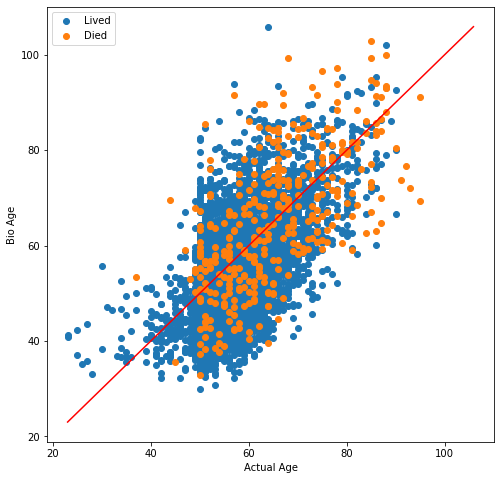

In [22]:
min_temp = min(list(data_cleaned["Age at CT"])+list(data_cleaned["Bio_Age"]))
max_temp =  max(list(data_cleaned["Age at CT"])+list(data_cleaned["Bio_Age"]))

plt.figure(figsize=(8, 8))
lived = (data_cleaned["DEATH_FLAG"] == 0)
dead = (data_cleaned["DEATH_FLAG"] == 1)

plt.plot([min_temp,max_temp ],[min_temp,max_temp],color = "red")

plt.scatter( list(data_cleaned.loc[lived , "Age at CT"]), list(data_cleaned.loc[lived ,"Bio_Age"]),label = "Lived")
plt.scatter( list(data_cleaned.loc[dead,"Age at CT"]), list(data_cleaned.loc[dead,"Bio_Age"]),label = "Died")

plt.xlabel("Actual Age")
plt.ylabel("Bio Age")
plt.legend()


In [28]:
for f in range(Folds):
    diff = []
    for r in data_cleaned.index:
        if data_cleaned.loc[r,"Fold"] == f:
            diff.append(data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"])
    offset = sum(diff)/len(diff)
    print(f'offset={offset}')
    
    bio_age_under_died = 0
    bio_age_over_died= 0 
    bio_age_over_died_age= 0 
    bio_age_under_lived = 0
    bio_age_over_lived = 0 

    lived_age_diff = 0
    died_age_diff = 0

    dead_list = []
    lived_list = []

    for r in data_cleaned.index:
        if data_cleaned.loc[r,"Fold"] == f:
            flag_sum = data_cleaned.loc[r,"CARD_FLAG"] + data_cleaned.loc[r,"DIA_FLAG"] + data_cleaned.loc[r,"FEM_FLAG"] + data_cleaned.loc[r,"ALZ_FLAG"] + data_cleaned.loc[r,"CANCER_FLAG"]
            if data_cleaned.loc[r,"DEATH_FLAG"] == 1:
                dead_list.append(data_cleaned.loc[r,"Bio_Age"])
                died_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
                if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
                    bio_age_under_died += 1
                else:
                    bio_age_over_died += 1

            else:
                lived_list.append(data_cleaned.loc[r,"Bio_Age"])
                lived_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
                if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
                    bio_age_under_lived += 1
                else:
                    bio_age_over_lived += 1

    print(f'dead={bio_age_over_died / (bio_age_over_died + bio_age_under_died)}  total:{bio_age_over_died + bio_age_under_died}')
    print(f'lived={bio_age_over_lived / (bio_age_over_lived + bio_age_under_lived)}  total:{bio_age_over_lived + bio_age_under_lived}')
    print('\n')
    #print(died_age_diff  /  (bio_age_over_died + bio_age_under_died))
    #print(lived_age_diff / (bio_age_over_lived + bio_age_under_lived))

offset=-3.3817445593664606
dead=0.6388888888888888  total:36
lived=0.47085201793721976  total:669


offset=-2.87800715617095
dead=0.6111111111111112  total:36
lived=0.4588938714499253  total:669


offset=-3.763551833771923
dead=0.4594594594594595  total:37
lived=0.44011976047904194  total:668


offset=-3.626776330482824
dead=0.5675675675675675  total:37
lived=0.4595808383233533  total:668


offset=-1.834024402112822
dead=0.6216216216216216  total:37
lived=0.4595808383233533  total:668


offset=-3.442986614023521
dead=0.5675675675675675  total:37
lived=0.4625748502994012  total:668


offset=-4.123662663516543
dead=0.5675675675675675  total:37
lived=0.47305389221556887  total:668


offset=-3.5914617272214957
dead=0.7027027027027027  total:37
lived=0.44461077844311375  total:668


offset=-2.591060647316974
dead=0.7027027027027027  total:37
lived=0.4550898203592814  total:668


offset=-2.5313091849346203
dead=0.6666666666666666  total:36
lived=0.44011976047904194  total:668




In [27]:
#offset = -0
bio_age_under_died = 0
bio_age_over_died= 0 
bio_age_over_died_age= 0 
bio_age_under_lived = 0
bio_age_over_lived = 0 

lived_age_diff = 0
died_age_diff = 0

dead_list = []
lived_list = []

for r in data_cleaned.index:
    flag_sum = data_cleaned.loc[r,"CARD_FLAG"] + data_cleaned.loc[r,"DIA_FLAG"] + data_cleaned.loc[r,"FEM_FLAG"] + data_cleaned.loc[r,"ALZ_FLAG"] + data_cleaned.loc[r,"CANCER_FLAG"]
    if data_cleaned.loc[r,"DEATH_FLAG"] == 1:
        dead_list.append(data_cleaned.loc[r,"Bio_Age"])
        died_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
        if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
            bio_age_under_died += 1
        else:
            bio_age_over_died += 1
            
    else:
        lived_list.append(data_cleaned.loc[r,"Bio_Age"])
        lived_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
        if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
            bio_age_under_lived += 1
        else:
            bio_age_over_lived += 1
            
print(bio_age_over_died / (bio_age_over_died + bio_age_under_died))
print(bio_age_over_lived / (bio_age_over_lived + bio_age_under_lived))

print(died_age_diff  /  (bio_age_over_died + bio_age_under_died))
print(lived_age_diff / (bio_age_over_lived + bio_age_under_lived))

0.5831062670299727
0.4247231367853936
2.8569166813821543
-0.8375922144740402


In [25]:
'''
0.5967302452316077
0.45764741095480393
3.083200350585072
-0.16934069569960142

'''

'''
add prob_list to each knn
0.6648501362397821
0.4570487877880874
6.606194460298611
-0.36283648113283445
'''

'''
use three categories
0.6430517711171662
0.39194851840766237
7.356447600000093
-0.40404314115535983

'''

'\nuse three categories\n0.6430517711171662\n0.39194851840766237\n7.356447600000093\n-0.40404314115535983\n\n'

No handles with labels found to put in legend.


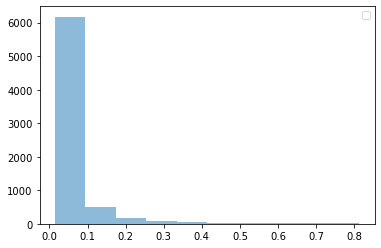

In [26]:
#plt.hist(dead_list, alpha=0.5, label='x')
#plt.hist(lived_list, alpha=0.5, label='y')
dead_actual_age = list(data_cleaned["Age at CT"])
plt.hist(prob_list, alpha=0.5)
plt.legend(loc='upper right')
plt.show()